In this notebook, we'll construct a very simple data science feature from some toy data and then use Hypervector to build a test fixture for  it. We can then run this test repeatedly with our automated test suites to continue to have confidence in our model in a production codebase

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Building a simple classifier

## Training data

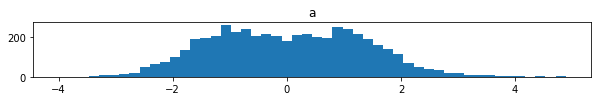

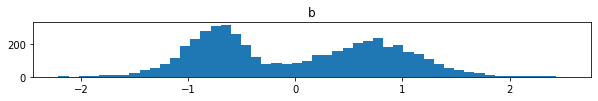

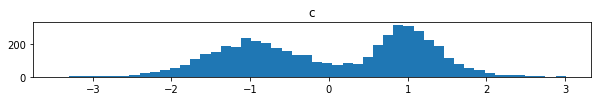

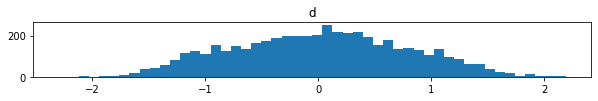

In [4]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=5000, 
    n_features=4, 
    n_informative=2,
    random_state=0
)

feature_names = ['a', 'b', 'c', 'd']
for data, feature_name in zip(list(zip(*X)), feature_names):
    plt.figure(figsize=(10, 1))
    plt.title(feature_name)
    plt.hist(data, bins=50);

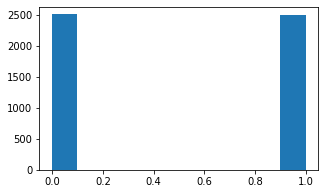

In [5]:
plt.figure(figsize=(5, 3))
plt.hist(y);

## Training a classifier

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from joblib import dump

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

pipeline.fit(X_train, y_train)

dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [7]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pipeline.predict(X_test))

0.976

# Writing a Hypervector test fixture

In [8]:
definition_json = {
    "definition_name": "Classifier test fixture",
    "features": [
        {
            "type": "float",
            "distribution": {
              "type": "gaussian", "mu": 0, "sigma": 2
            }
        },
        {
            "type": "float",
            "distribution": {
                "type": "mixture",
                "components": [
                    {"mu": -0.75, "sigma": 0.5, "weight": 2},
                    {"mu": 0.75, "sigma": 0.5, "weight": 1}
                ]
            }
        },
        {
            "type": "float",
            "distribution": {
                "type": "mixture",
                "components": [
                    {"mu": -1, "sigma": 0.5, "weight": 1},
                    {"mu": 1, "sigma": 0.5, "weight": 2}
                ]
            }
        },
        {
            "type": "float",
            "distribution": {
                "type": "gaussian", "mu": 0, "sigma": 2
            }
        },
        
    ]
}

In [9]:
import hypervector
hypervector.API_KEY = "32I8kjJNTr6i6x0U7ir2Y_tkm1r2RoJnrW962kbOHbY4Jw8"

# Create new Hypervector Project
project = hypervector.Project.new()

# Add Definition from JSON
definition = hypervector.Definition.new(
    definition=definition_json,
    project_uuid=project.project_uuid
)

# Generate Ensemble of 10000 examples from Definition
ensemble = hypervector.Ensemble.new(
    definition_uuid=definition.definition_uuid,
    size=10000
)

In [10]:
print(definition.definition_uuid)

32b74bf4-06b8-4c14-a5d2-4c6db4d9fb2c


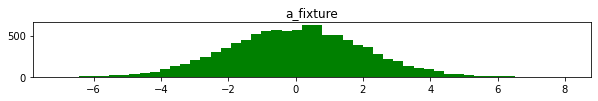

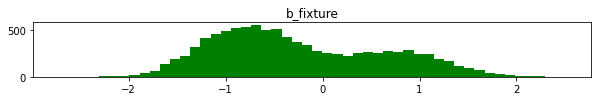

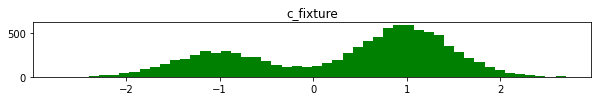

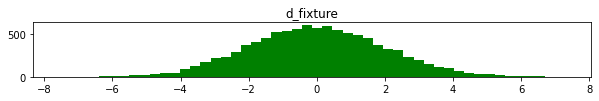

In [11]:
test_fixture_data = ensemble.hypervectors()

fixture_names = ['a_fixture', 'b_fixture', 'c_fixture', 'd_fixture']
for fixture_data, fixture_name in zip(list(zip(*test_fixture_data)), fixture_names):
    plt.figure(figsize=(10,1))
    plt.title(fixture_name)
    plt.hist(fixture_data, bins=50, color='green');

# Benchmarking classifier output for testing

In [12]:
# Create Hypervector Benchmark using Ensemble and model output
benchmark = hypervector.Benchmark.new(
    ensemble=ensemble,
    expected_output=pipeline.predict(test_fixture_data)
)

In [13]:
# Test using same data to verify Benchmark created successfully
benchmark.assert_equal(pipeline.predict(test_fixture_data))

{'assertion_uuid': '71f990e9-e336-4207-b146-870f72093d1b',
 'timestamp': '2021/06/08 13:06:42',
 'benchmark_uuid': 'fce8ef24-fc2f-4d0d-819b-209289a02734',
 'ensemble_uuid': 'e6ed88c0-6fb0-4b6a-bad3-90adfc0e3d17',
 'asserted': True,
 'diff': None}

### We're now ready to use this Benchmark in our test suites!